In [1]:
!nvidia-smi -L

GPU 0: NVIDIA RTX A6000 (UUID: GPU-ba304e17-954b-c9d8-99b2-d684e9848ac9)
GPU 1: NVIDIA RTX A6000 (UUID: GPU-5e578c09-49e8-9764-0601-508def3417e2)
GPU 2: NVIDIA RTX A6000 (UUID: GPU-f733554c-70c1-eb3f-2700-ed99821dfba3)
GPU 3: NVIDIA RTX A6000 (UUID: GPU-af832ed4-1607-289d-af20-7cd8cf2f9ed2)
GPU 4: NVIDIA RTX A6000 (UUID: GPU-c957aadf-c7c5-f273-2931-ed8b5308c454)
GPU 5: NVIDIA RTX A6000 (UUID: GPU-3183908f-a23b-e394-f96a-d6e03c3d3e22)
GPU 6: NVIDIA RTX A6000 (UUID: GPU-d62bae97-7c4d-c348-b593-235a32f4313a)
GPU 7: NVIDIA RTX A6000 (UUID: GPU-a0461f3f-c91c-40fa-9bf4-a8fa1a0bef59)


In [1]:
!which python

/home/josephmiller/.conda/envs/perspective_point/bin/python


(Only works on Google Colab) Ensure torch and torchvision are installed. If pytorch3d is not installed, install it using the following cell: (Source: https://pytorch3d.org/tutorials/deform_source_mesh_to_target_mesh)

In [2]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

/home/josephmiller/.conda/envs/perspective_point/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [140]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, ToTensor, Resize, CenterCrop, Normalize, Compose
import torchvision.models as models

# Util function for loading point clouds|
import numpy as np

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    look_at_view_transform,
    look_at_rotation,
    FoVOrthographicCameras, 
    FoVPerspectiveCameras,
    PointsRasterizationSettings,
    RasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# from torchvision.models import efficientnet, EfficientNet_V2_M_Weights
from torch.nn.functional import cosine_similarity
from PIL import Image
from img2vec import Img2Vec
import pandas as pd

In [77]:
IMAGE_SIZE = 224
# Load the pretrained model
img_model = models.resnet18(pretrained=True).to(device)
# Use the model object to select the desired layer
layer = img_model._modules.get('avgpool')
# Set model to evaluation mode
img_model.eval()

transforms_pil = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transforms_tensor = Compose([
    Resize(256),
    CenterCrop(224),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def get_vector(image):
    # Create a PyTorch tensor with the transformed image
    if(torch.is_tensor(image)):
        t_img = transforms_tensor(image)
    else:
        t_img = transforms_pil(image).to(device)
    # Create a vector of zeros that will hold our feature vector
    # The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512).to(device)

    # Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.flatten())                 # <-- flatten

    # Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # Run the model on our transformed image
    # with torch.no_grad():
    img_model(t_img.unsqueeze(0))
    # Detach our copy function from the layer
    h.remove()
    # Return the feature vector
    return my_embedding


In [164]:
img2vec = Img2Vec(cuda=True)

transform_to_tensor = ToTensor()
resize_transform = Resize(IMAGE_SIZE)
# Read in an image (rgb format)
# img = Image.open('cat_face_line_drawing.jpeg')
# img_arr = ['cat_face_line_drawing.jpeg', 'guitar.jpeg', 'The-Triskele.jpeg']
img_arr = ['cat_face_line_drawing.jpeg', 'dog_face.jpeg', 'guitar.jpeg']
# if img.mode != 'RGB':
#     img = img.convert('RGB')
# tensor_img = transform_to_tensor(img)
# print('tensor_image.shape', tensor_img.shape)
# # cat_vec = img2vec.get_vec(img, tensor=True).requires_grad_(True)
# img_vec = get_vector(img).clone().detach().to(device)
# print('cat_vec', cat_vec)
img_tensors = []
for img_name in img_arr:
    img = Image.open(img_name)
    img_tensor = transforms_pil(img).permute(1, 2, 0).unsqueeze(0).to(device).requires_grad_(True)
    img_tensors.append(img_tensor)
img_tensor = torch.cat(img_tensors, dim=0)

/home/josephmiller/.conda/envs/perspective_point/lib/python3.8/site-packages/pytorch3d/transforms/transform3d.py:802: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


i: 0 loss -1925.3726806640625
i: 50 loss -1956.1602783203125
i: 100 loss -1963.444091796875
i: 150 loss -1969.161865234375
i: 200 loss -1969.0360107421875
i: 250 loss -1974.3372802734375
i: 300 loss -1977.5362548828125


/tmp/ipykernel_2960214/1350135168.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 10))


i: 350 loss -1980.371337890625
i: 400 loss -1981.376708984375
i: 450 loss -1980.6986083984375
i: 500 loss -1984.2315673828125
i: 550 loss -1983.822265625
i: 600 loss -1985.1976318359375
i: 650 loss -1985.4124755859375


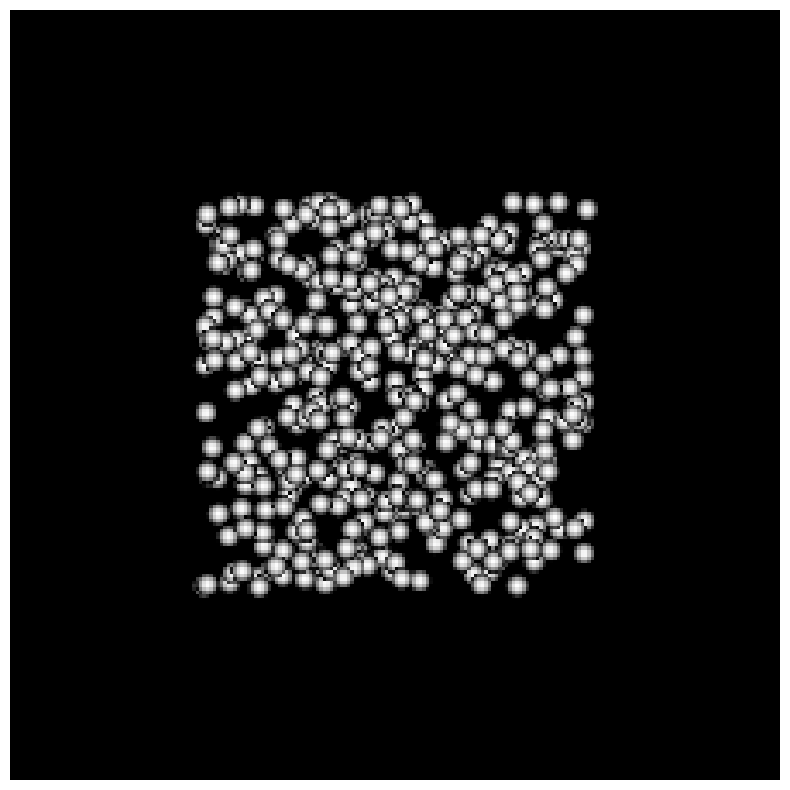

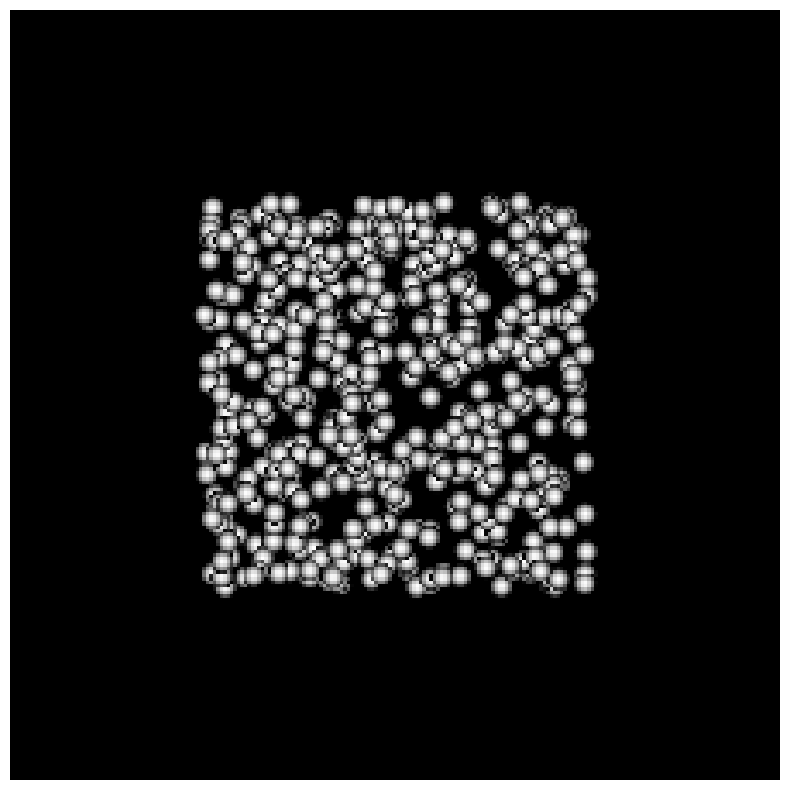

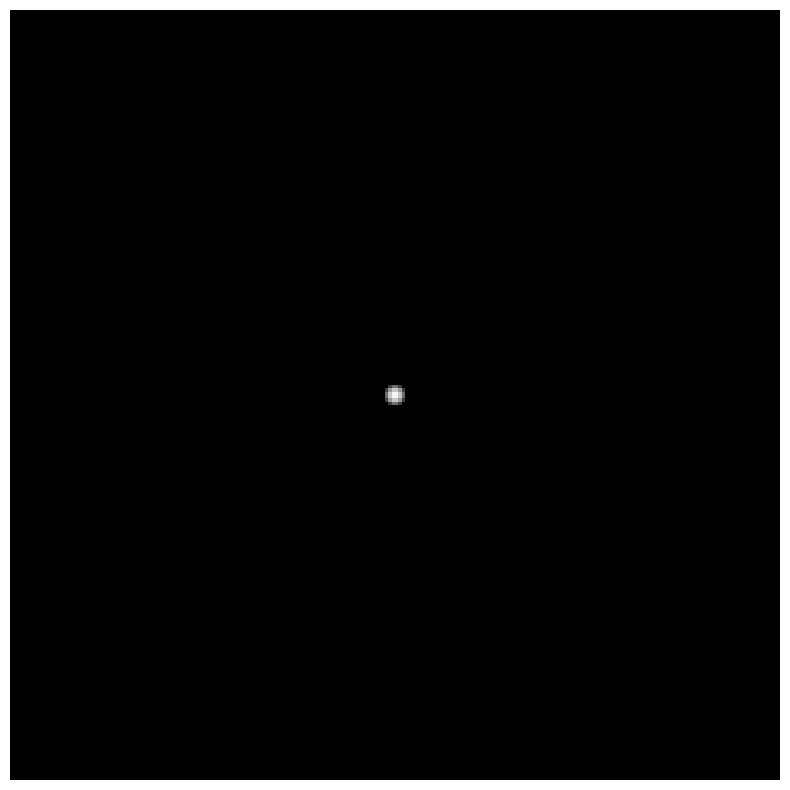

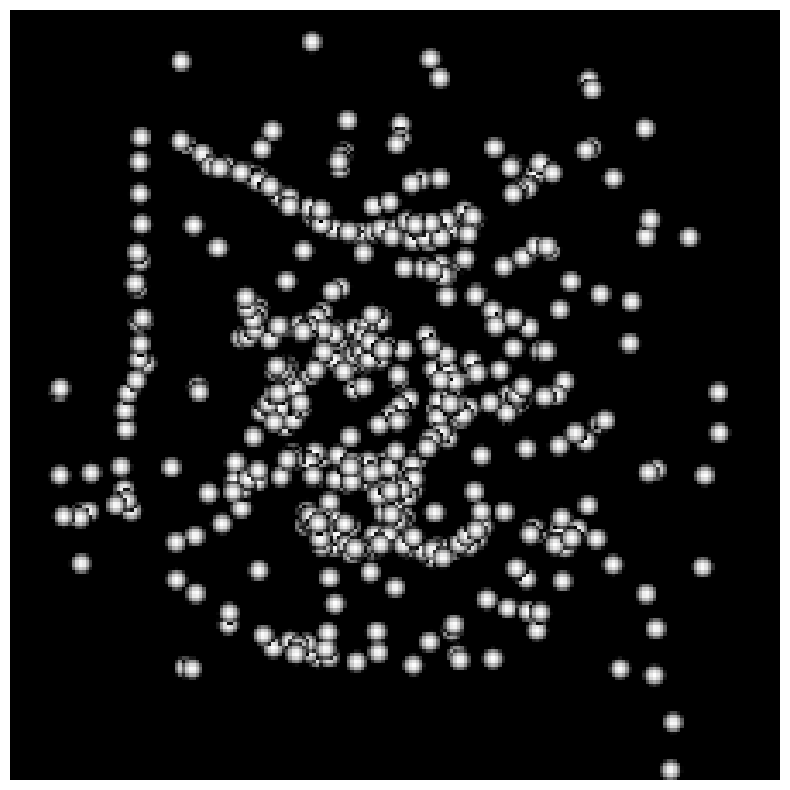

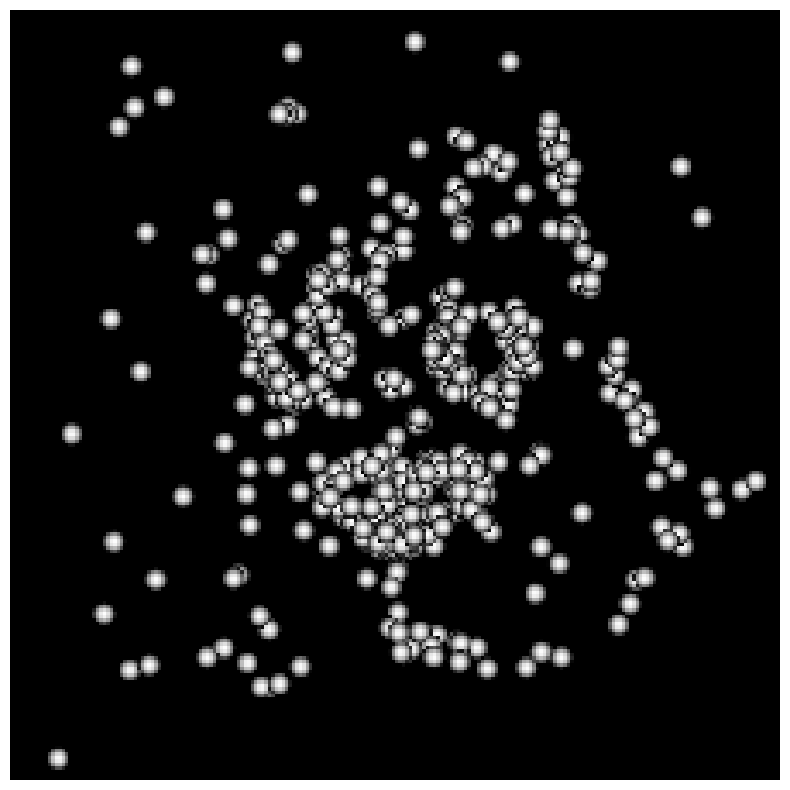

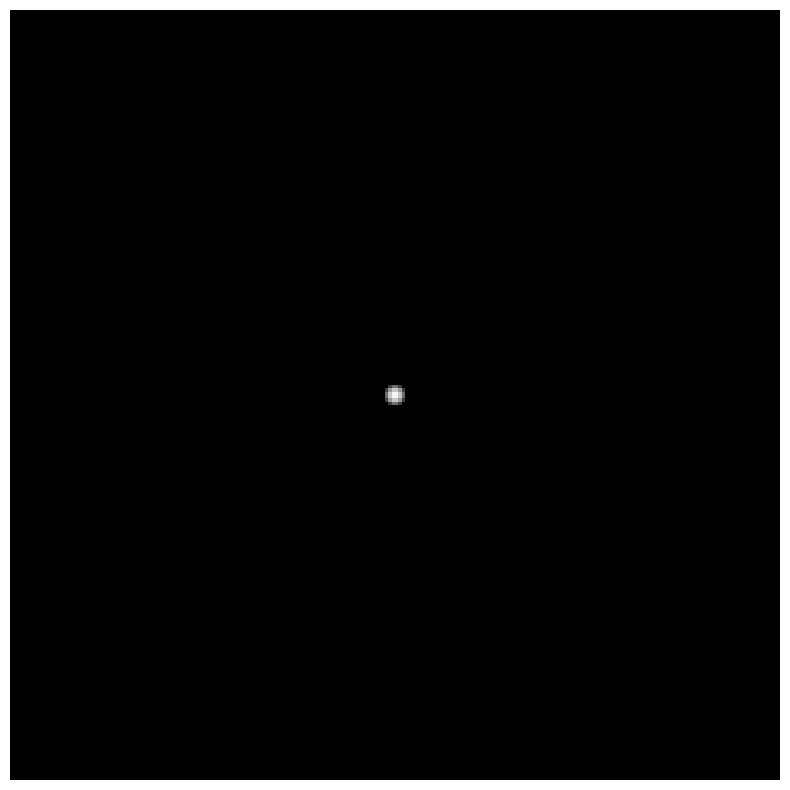

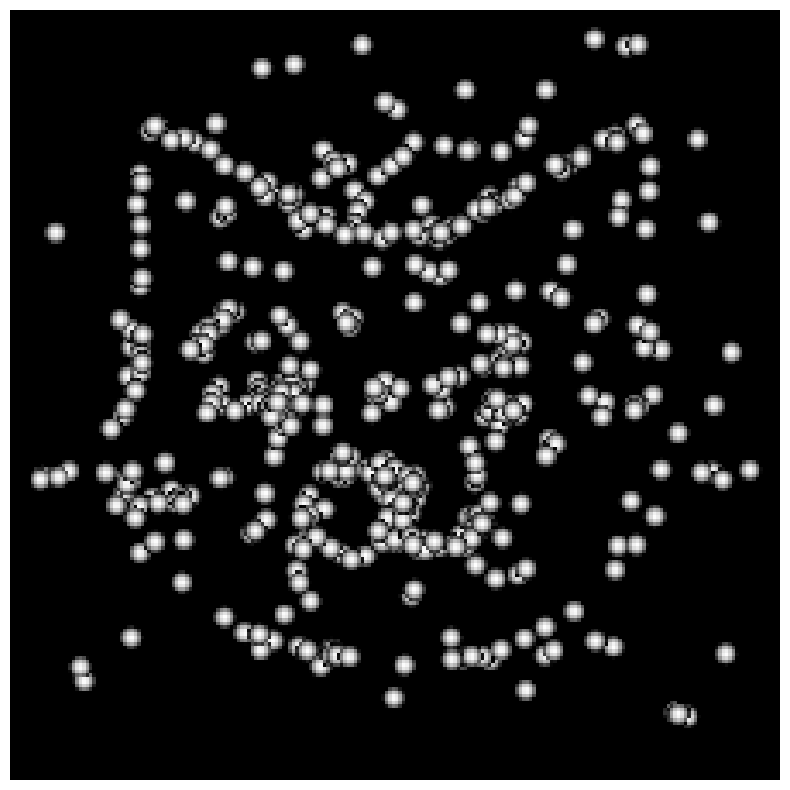

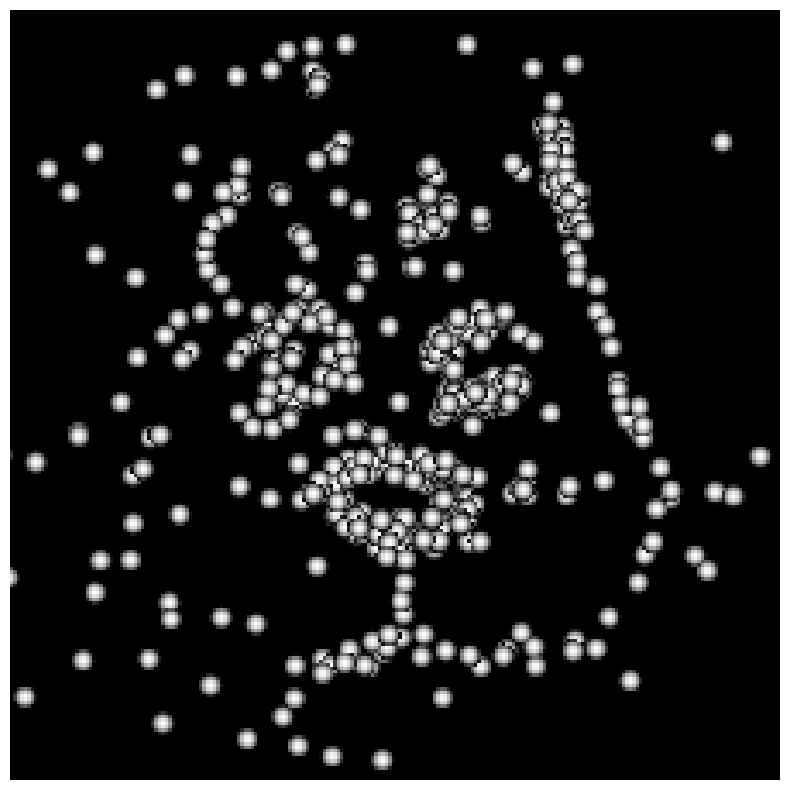

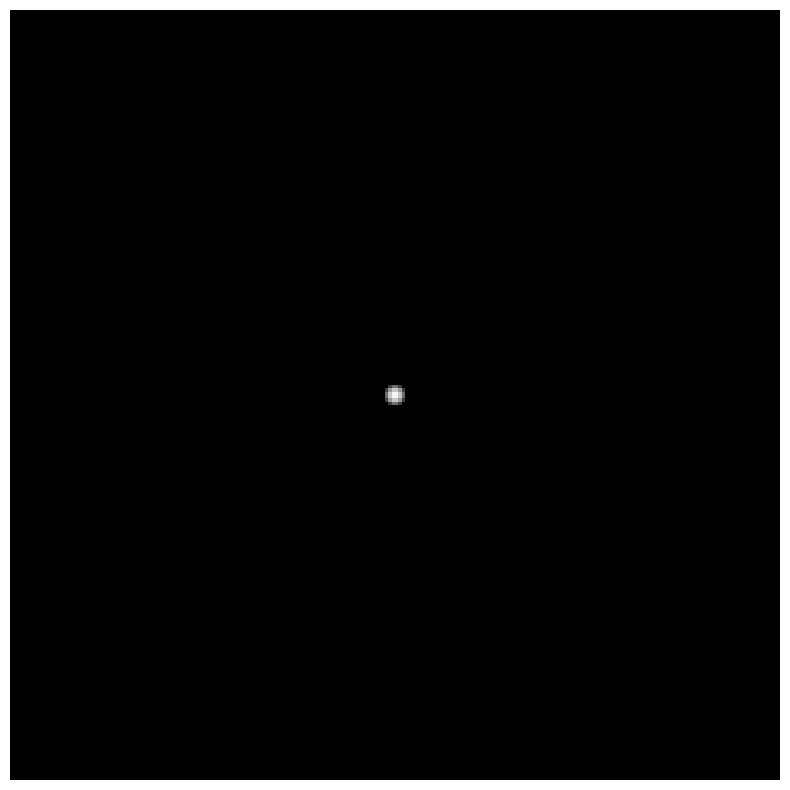

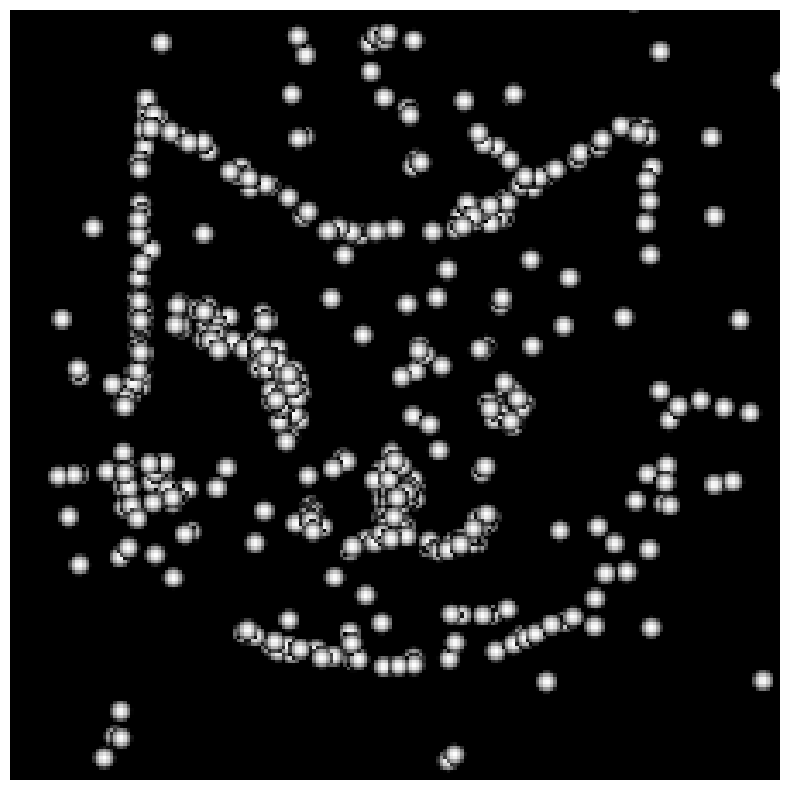

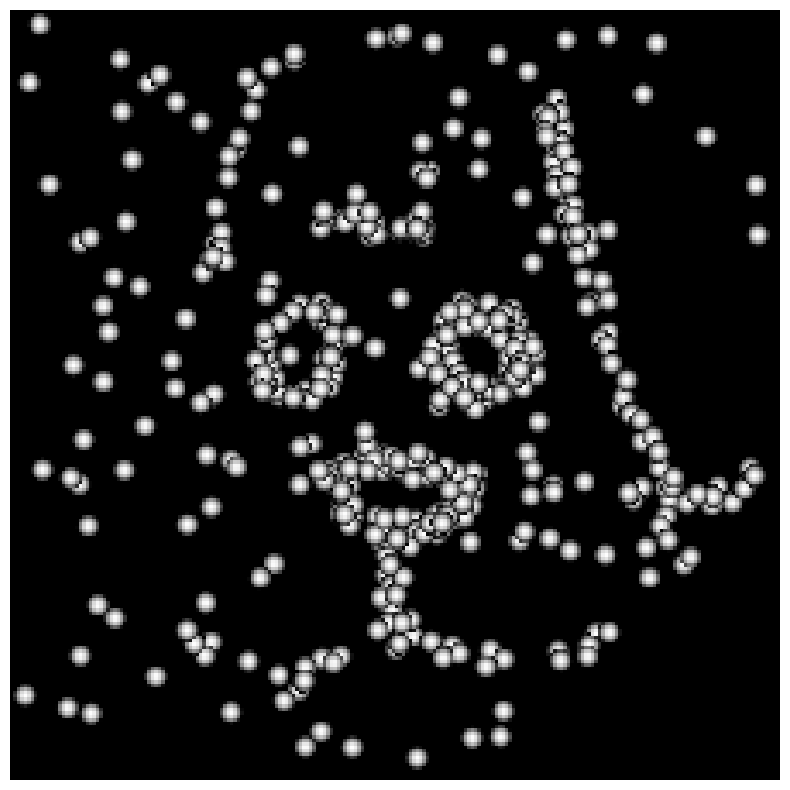

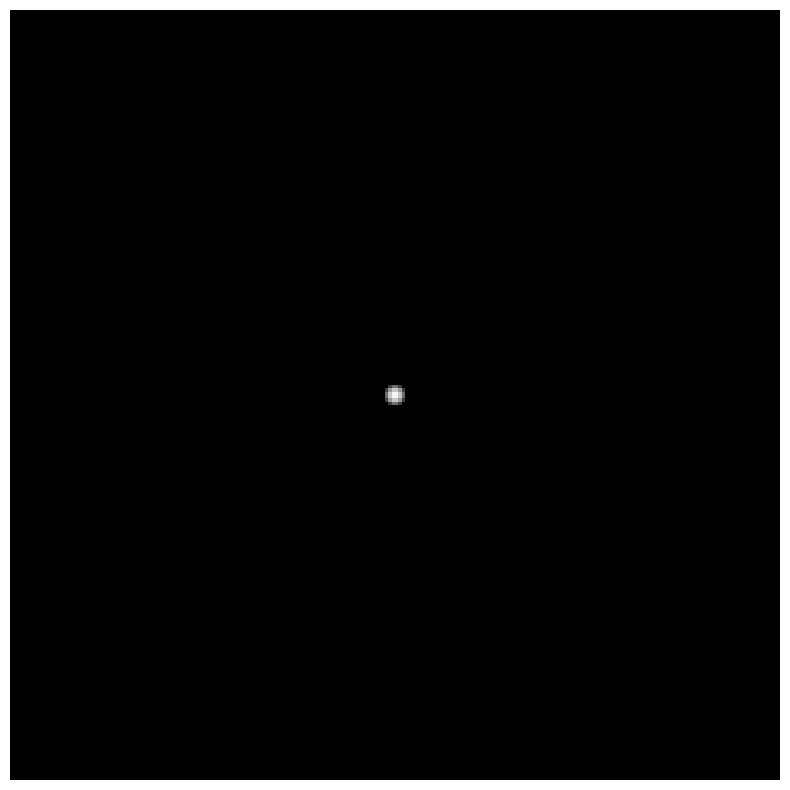

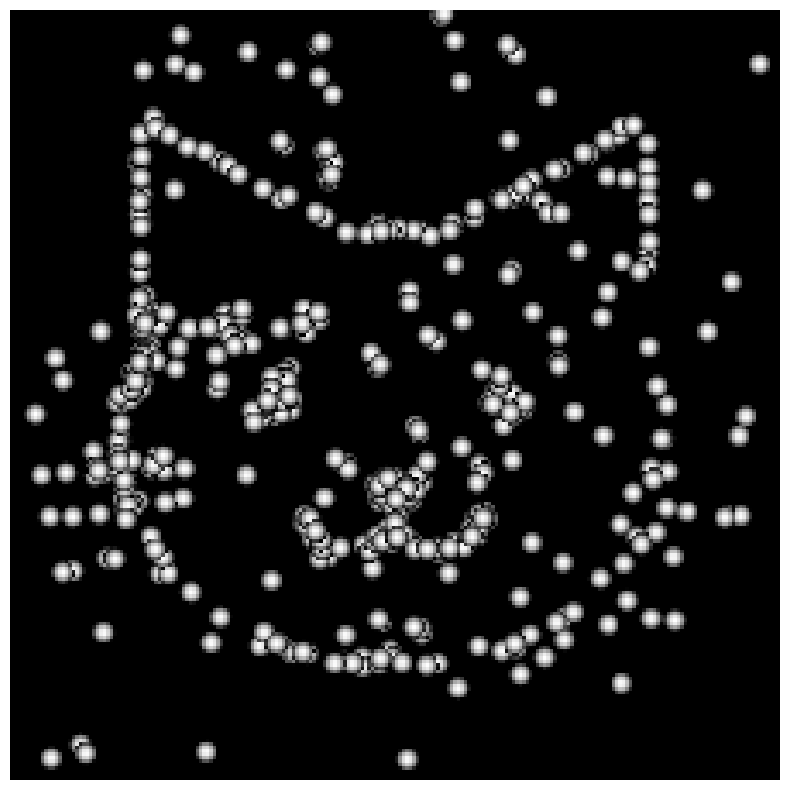

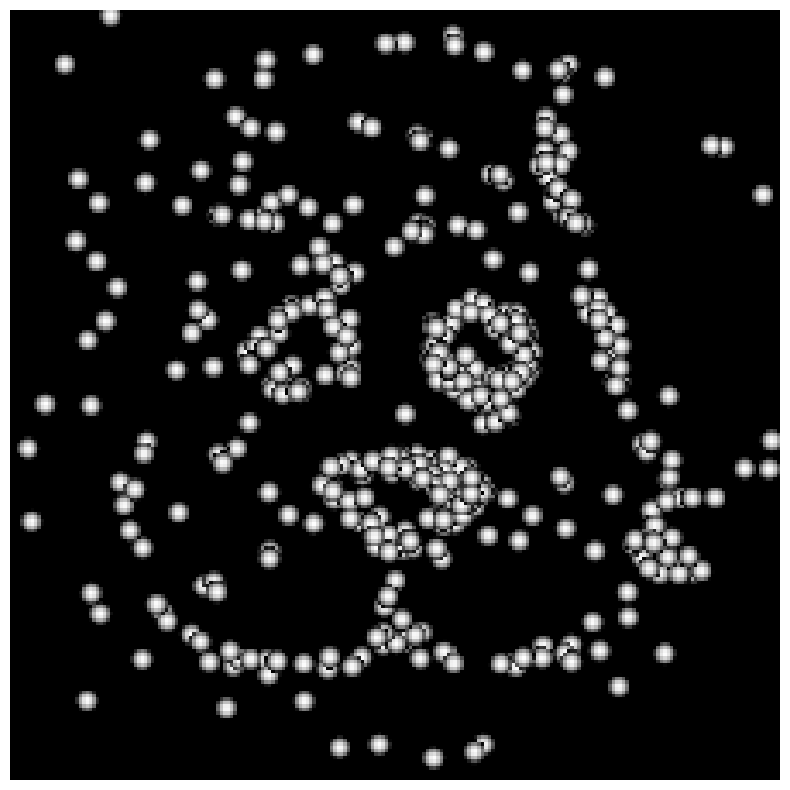

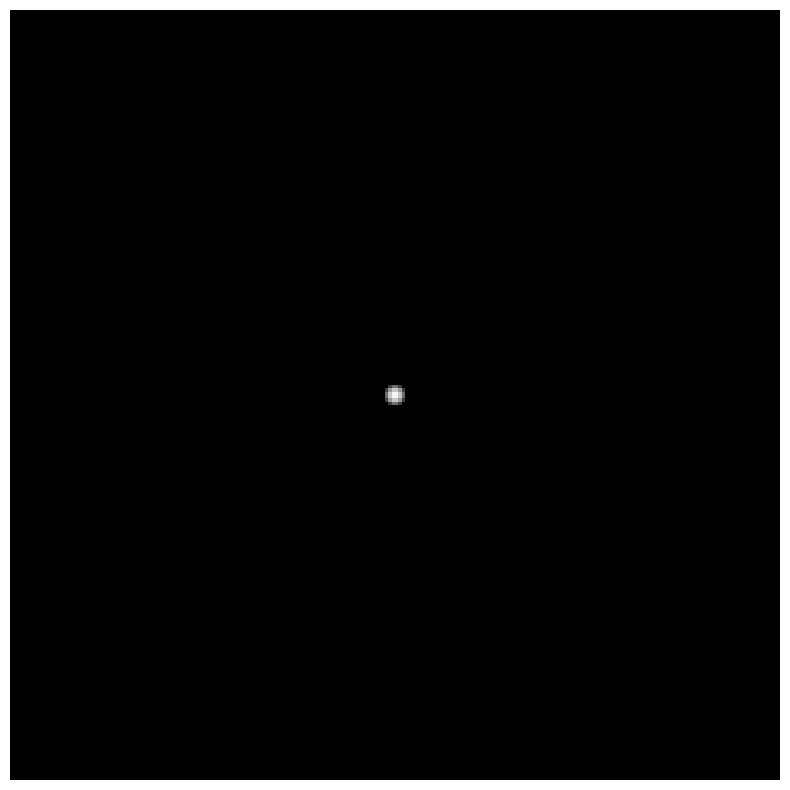

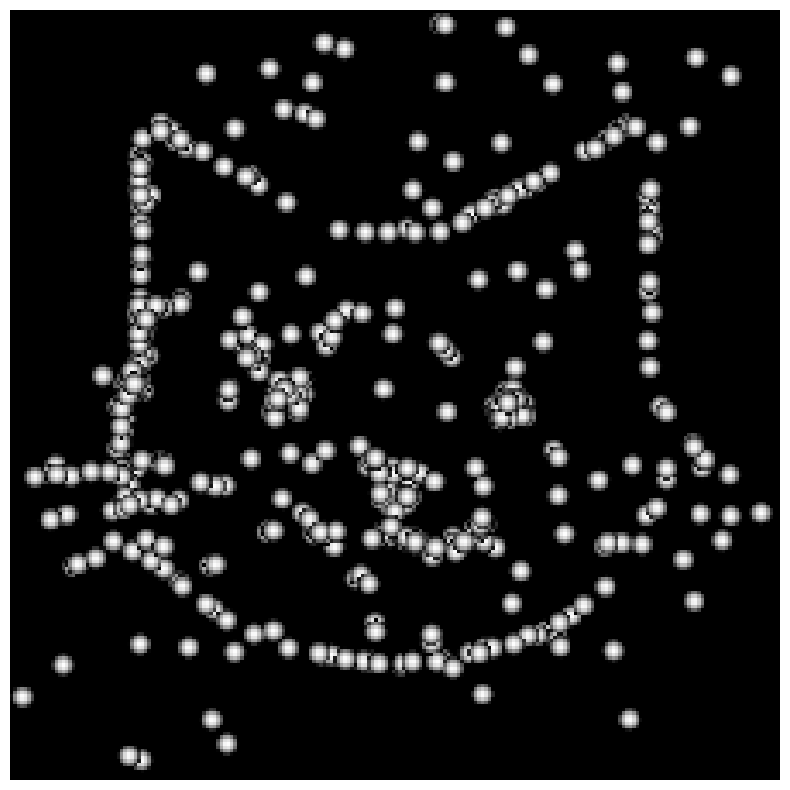

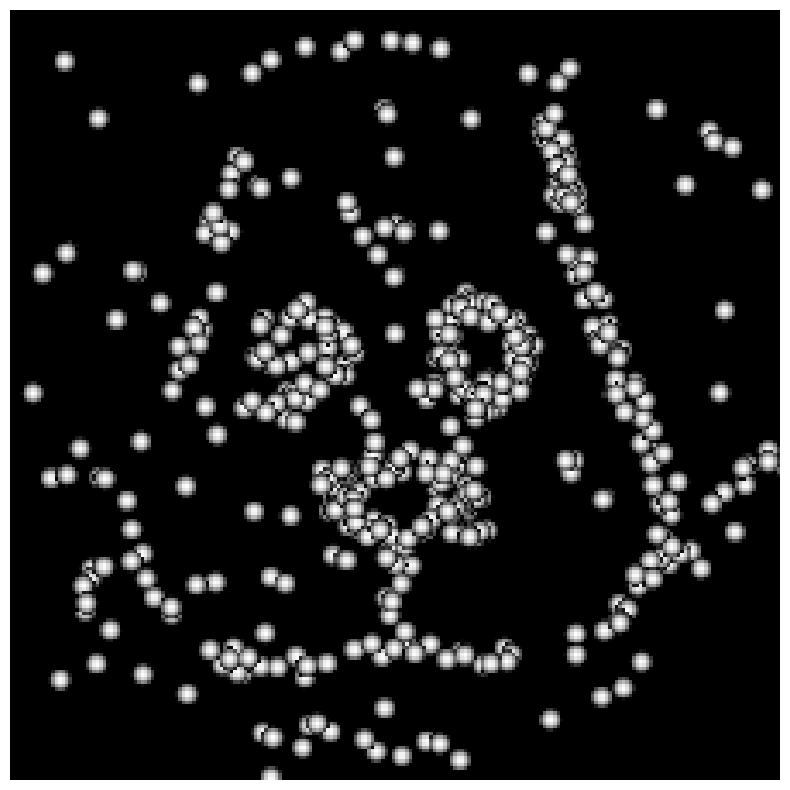

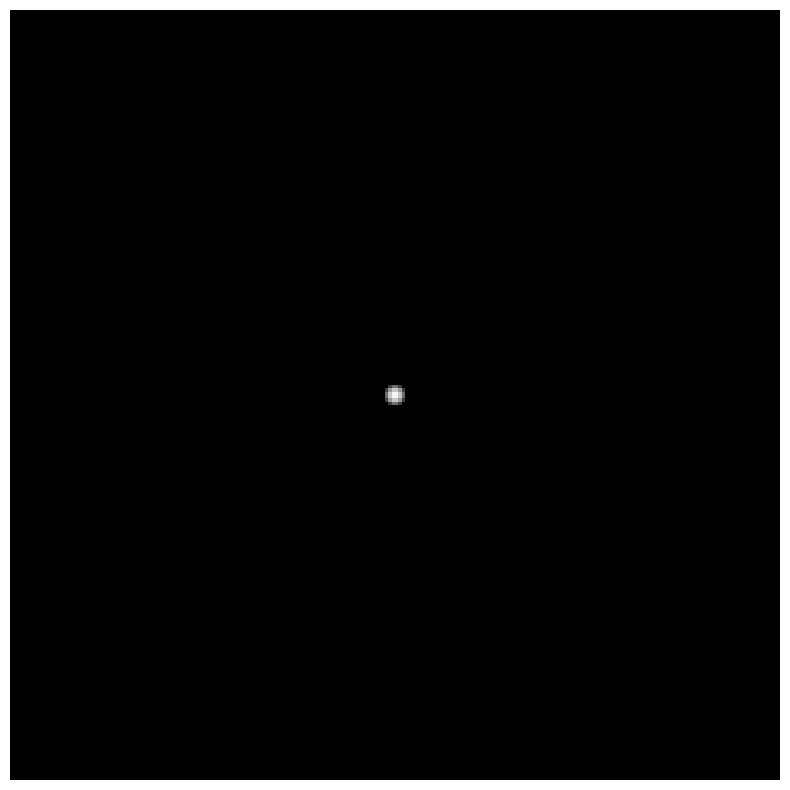

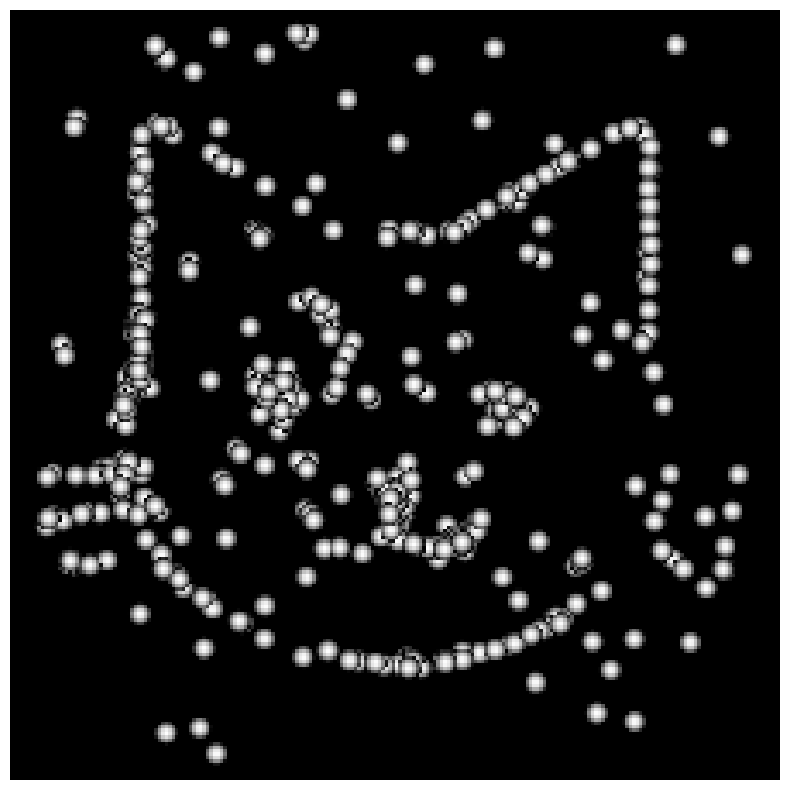

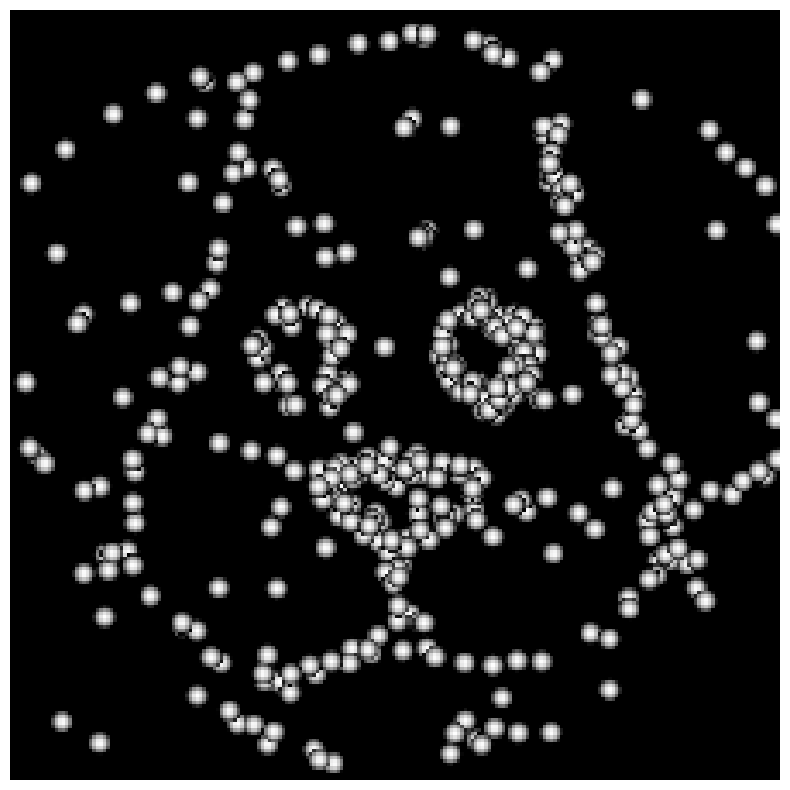

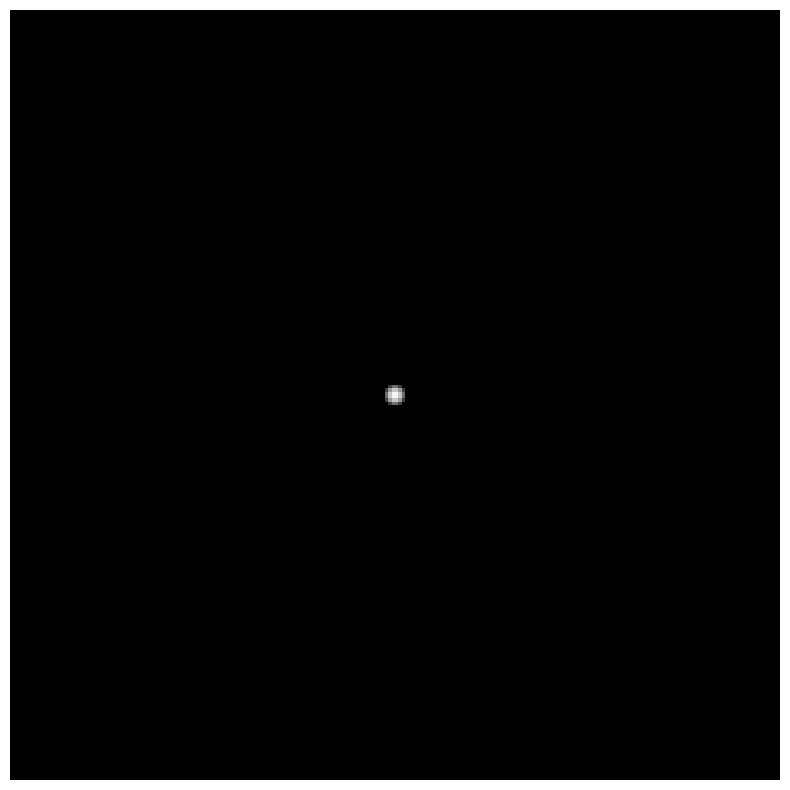

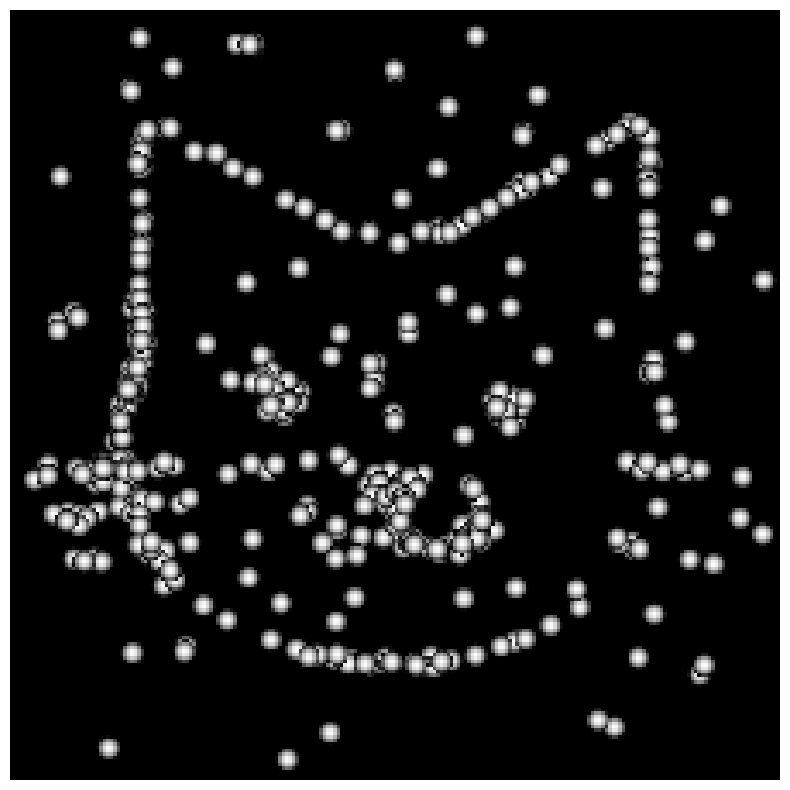

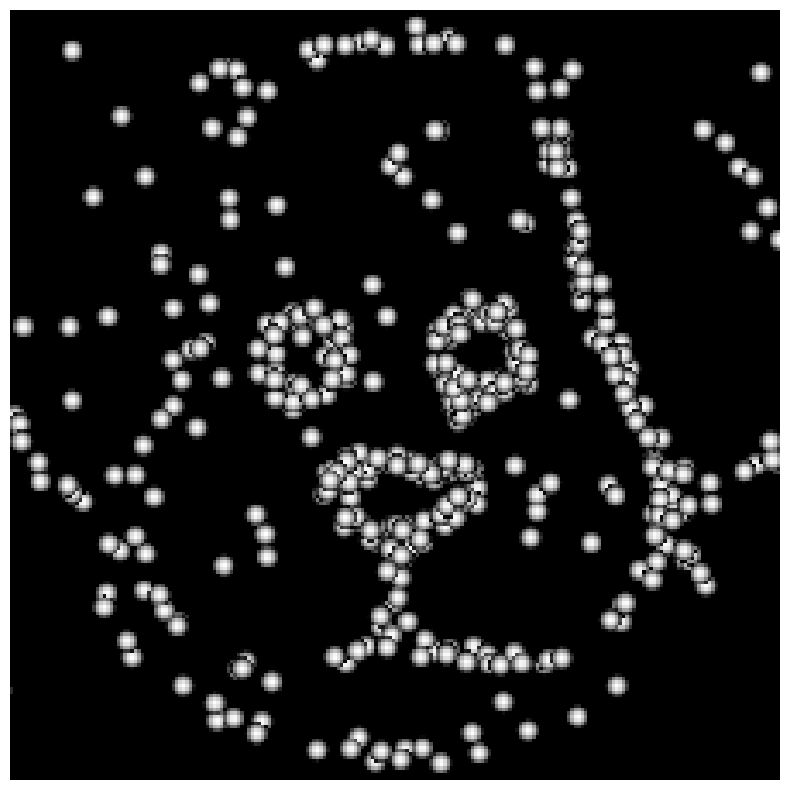

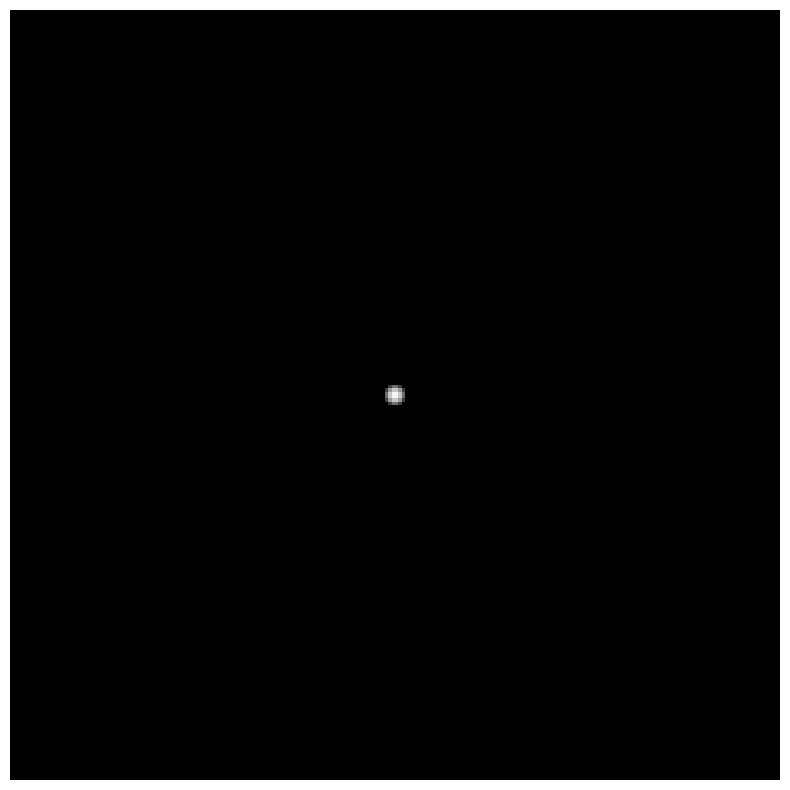

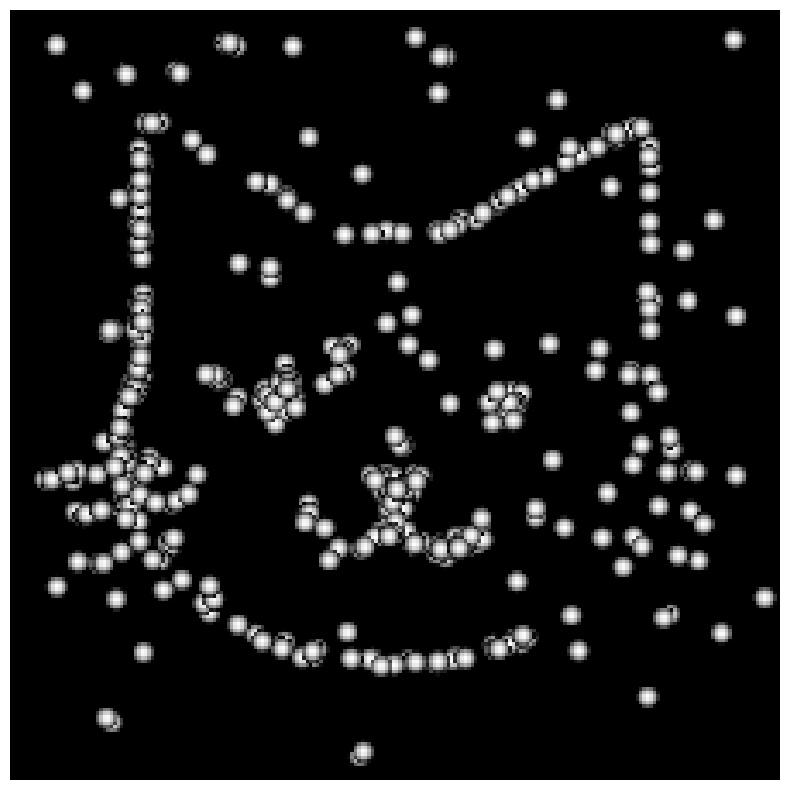

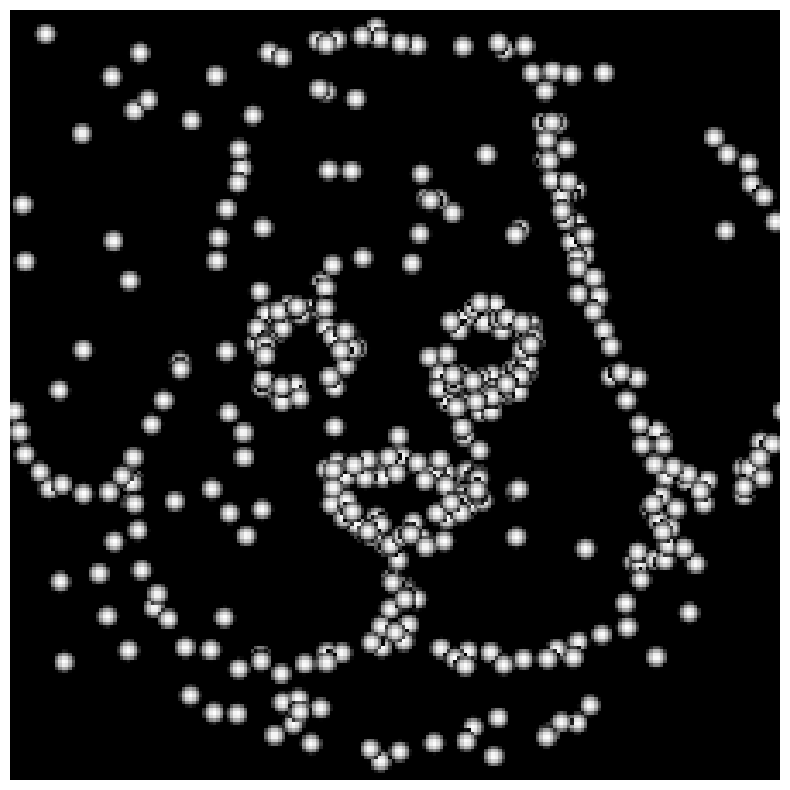

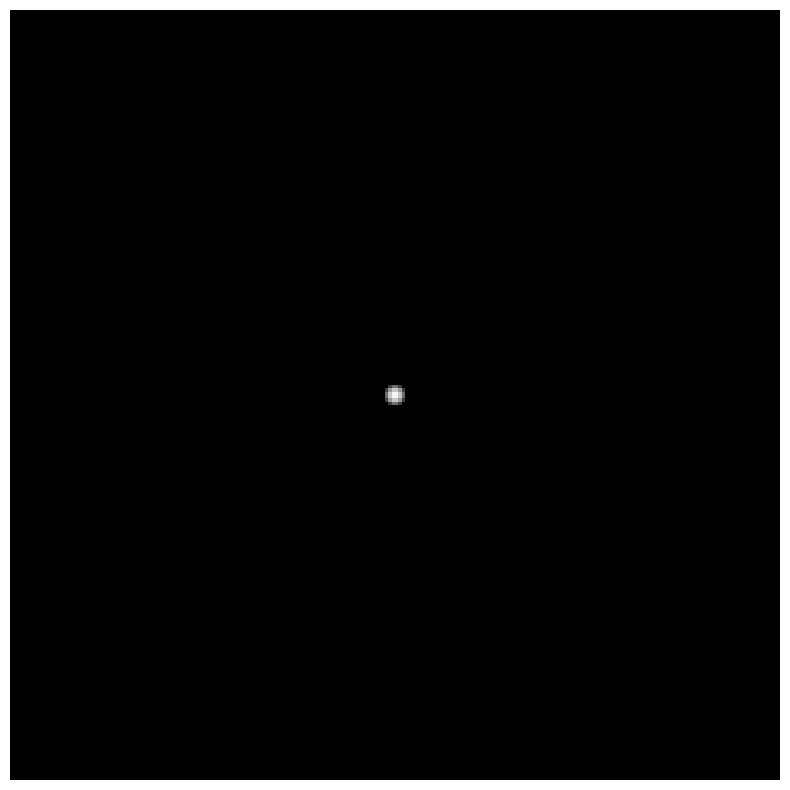

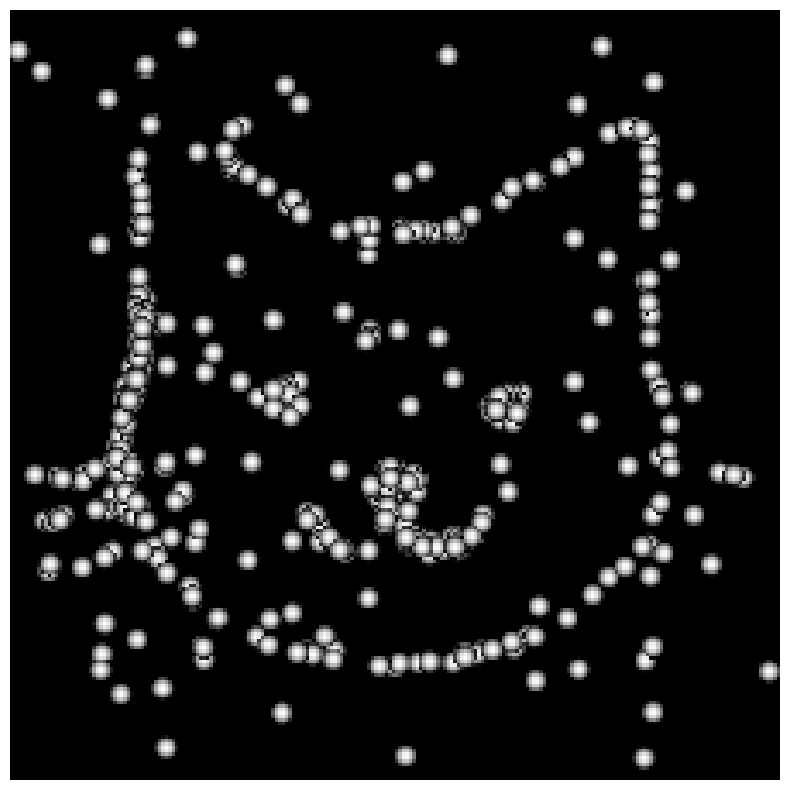

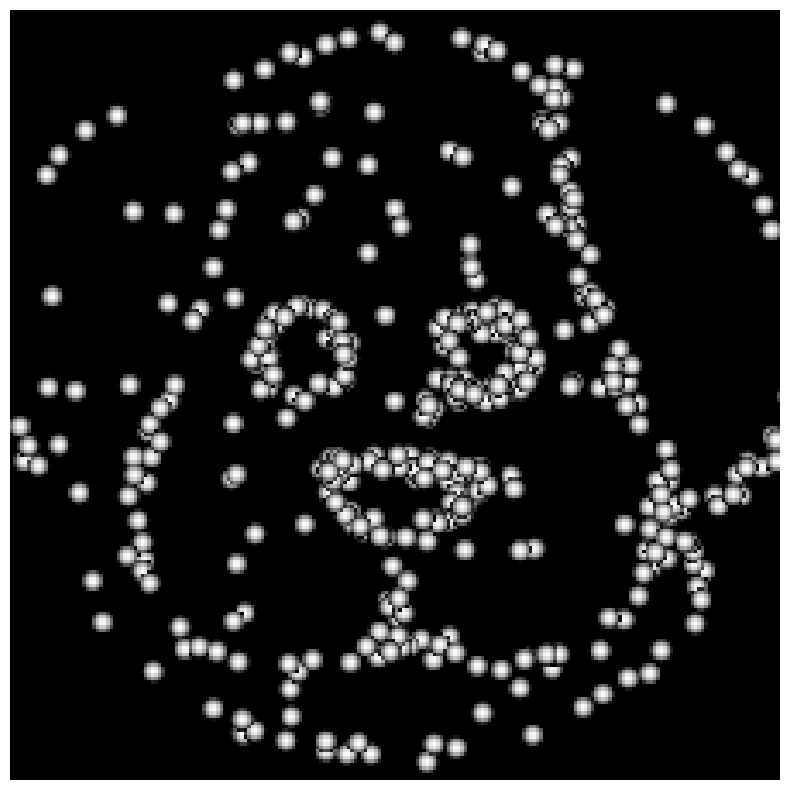

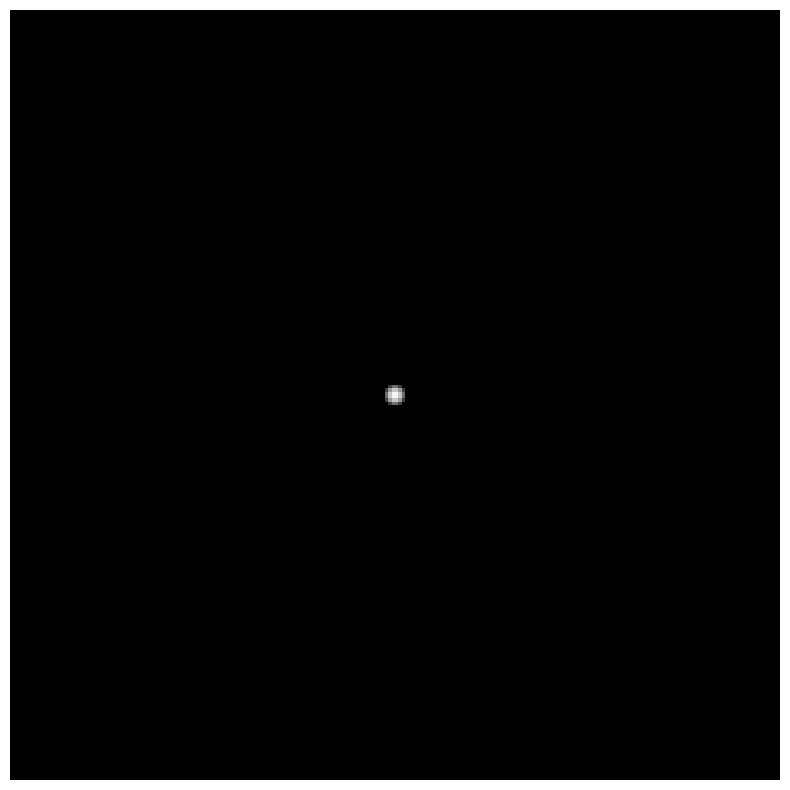

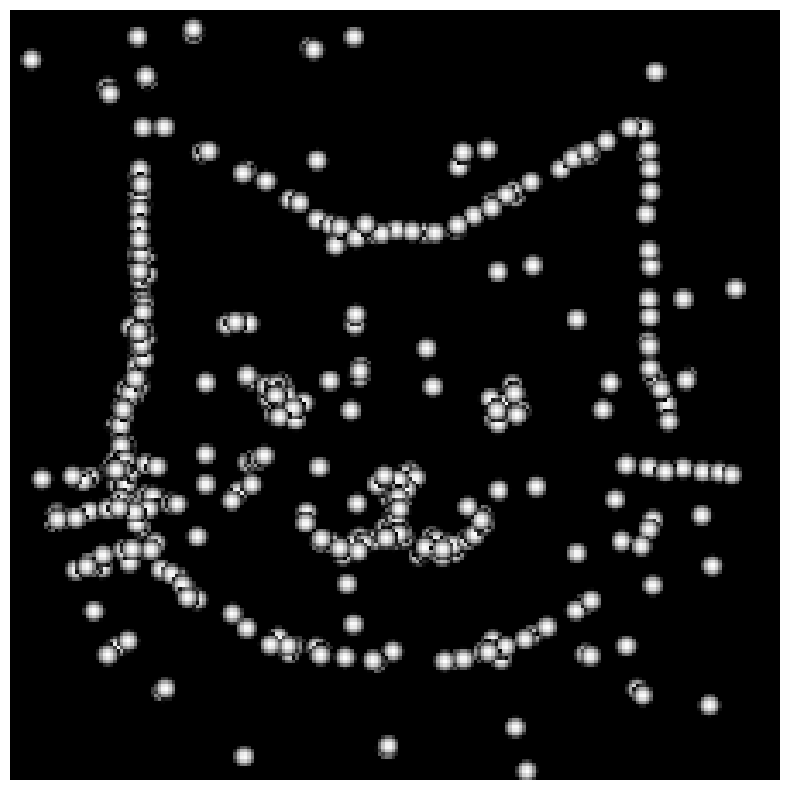

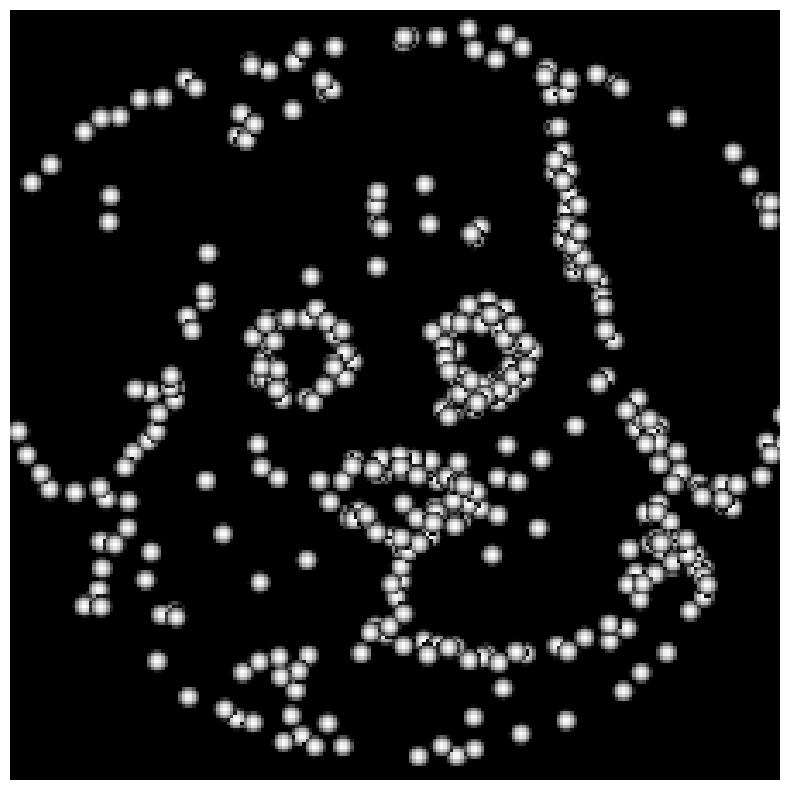

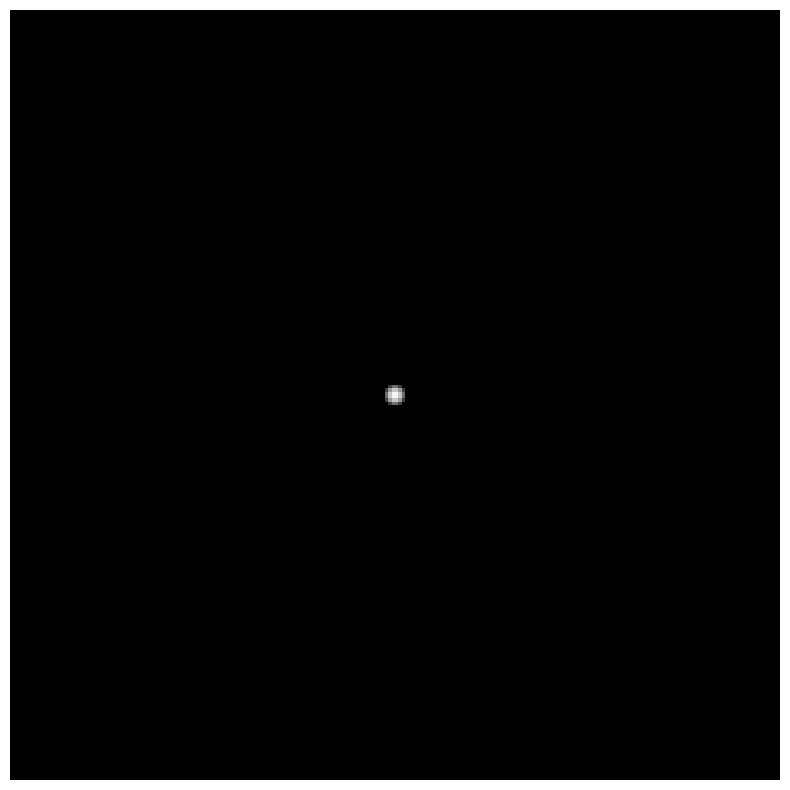

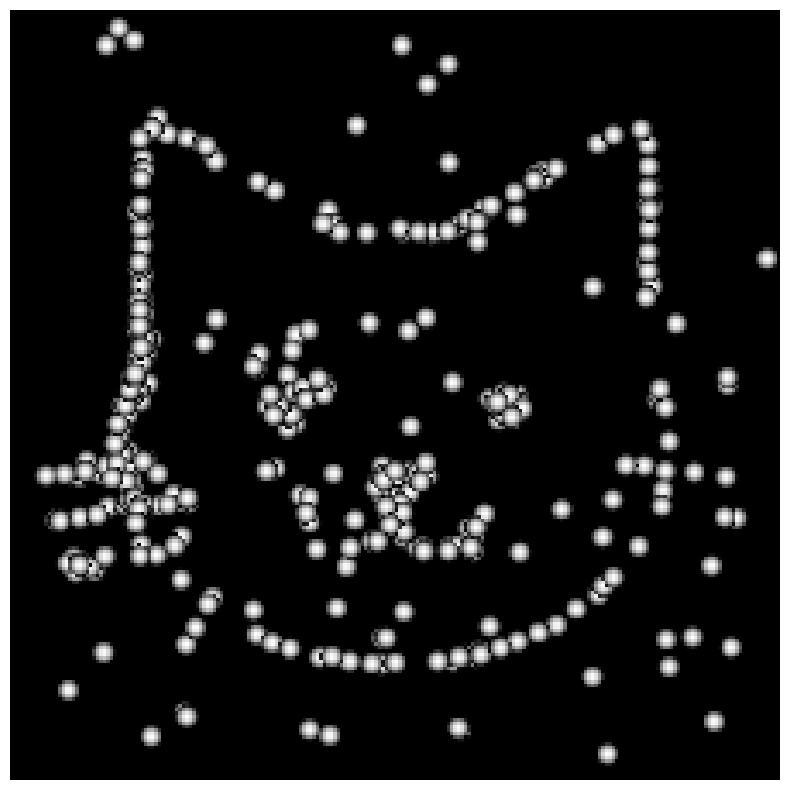

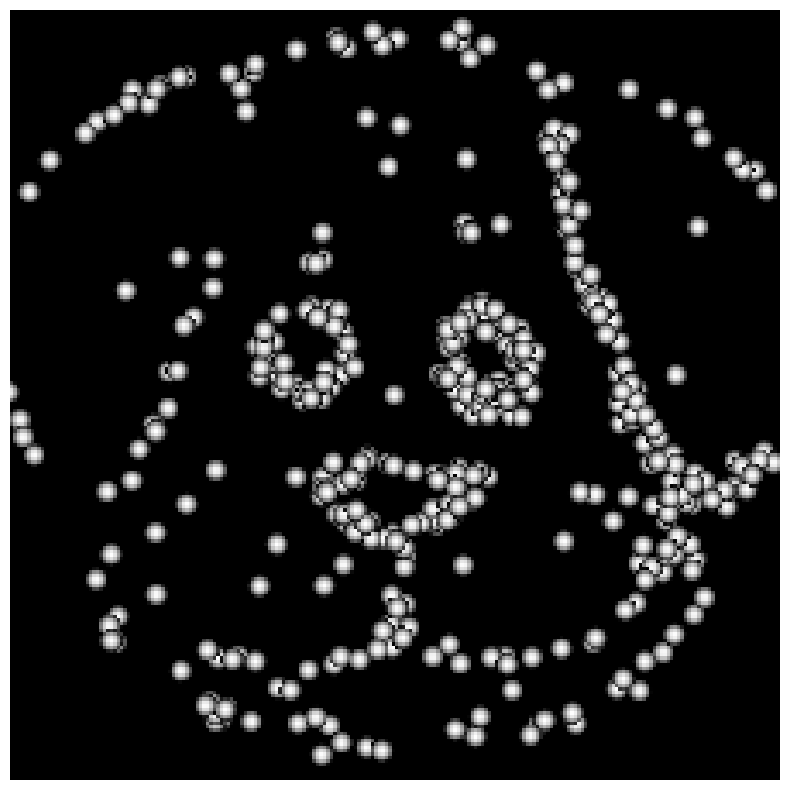

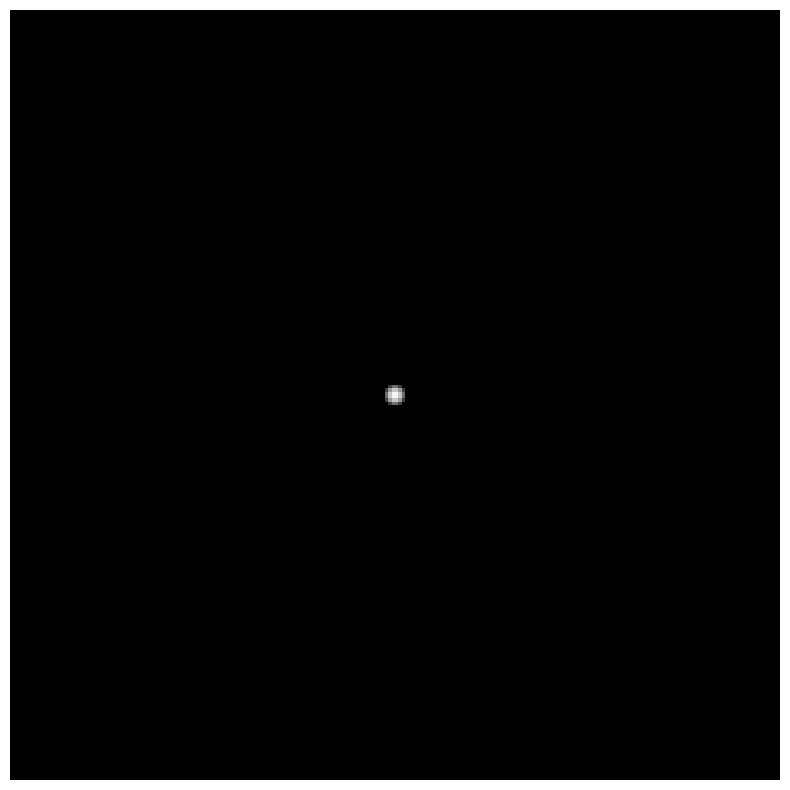

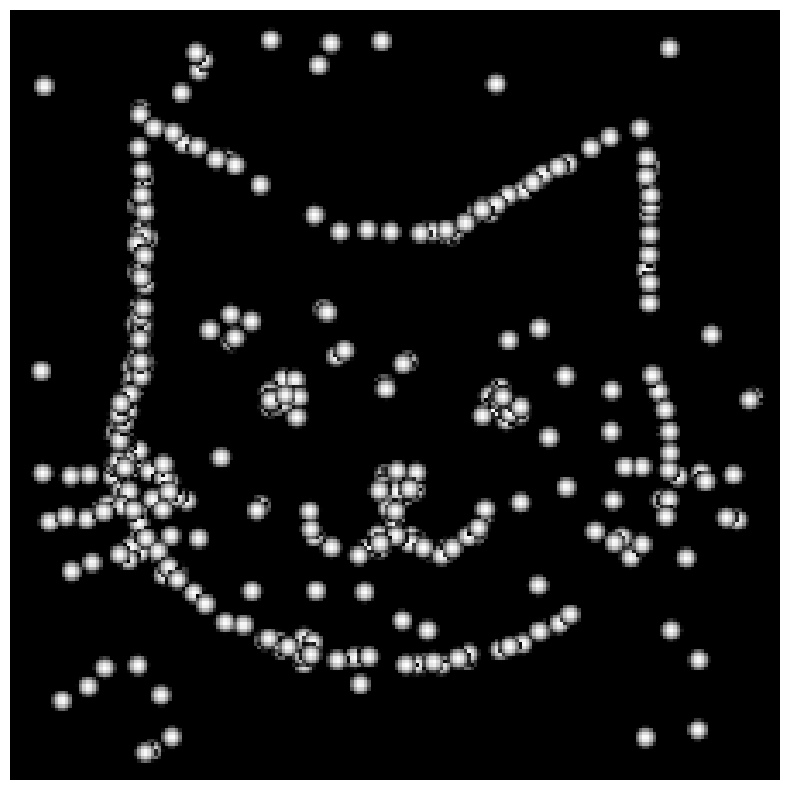

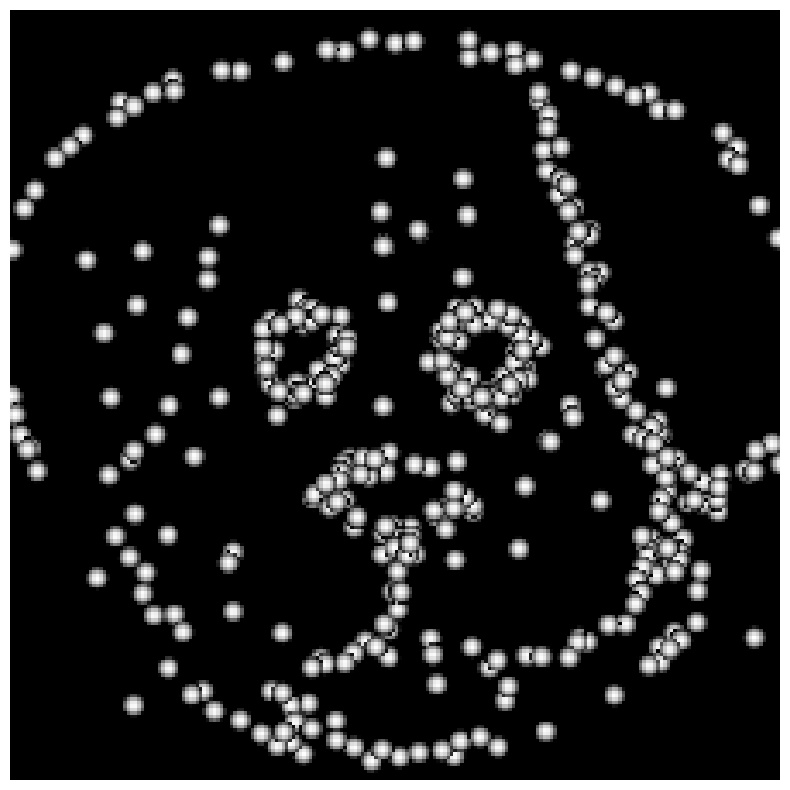

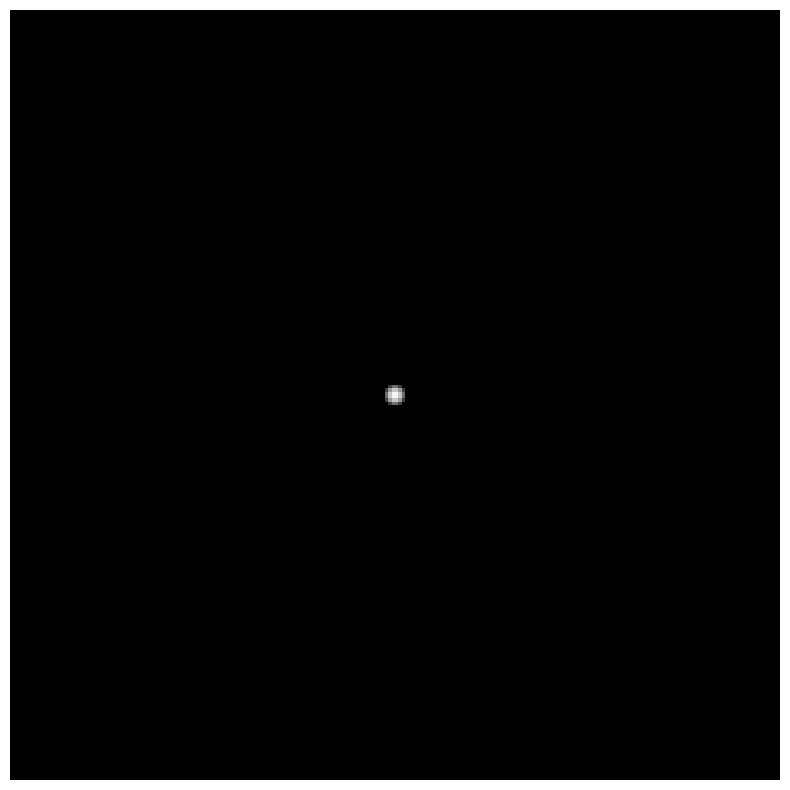

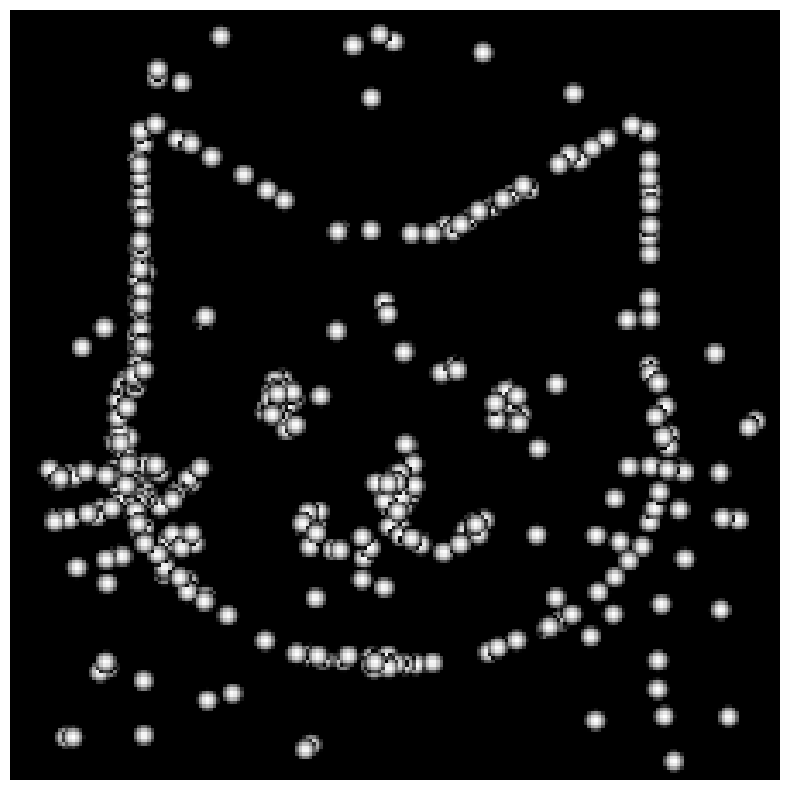

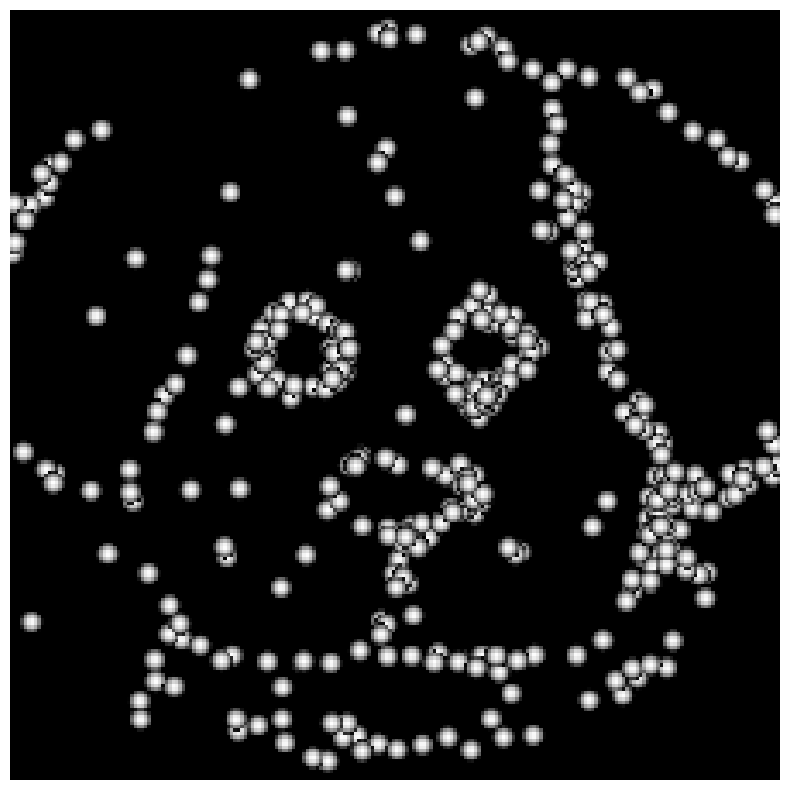

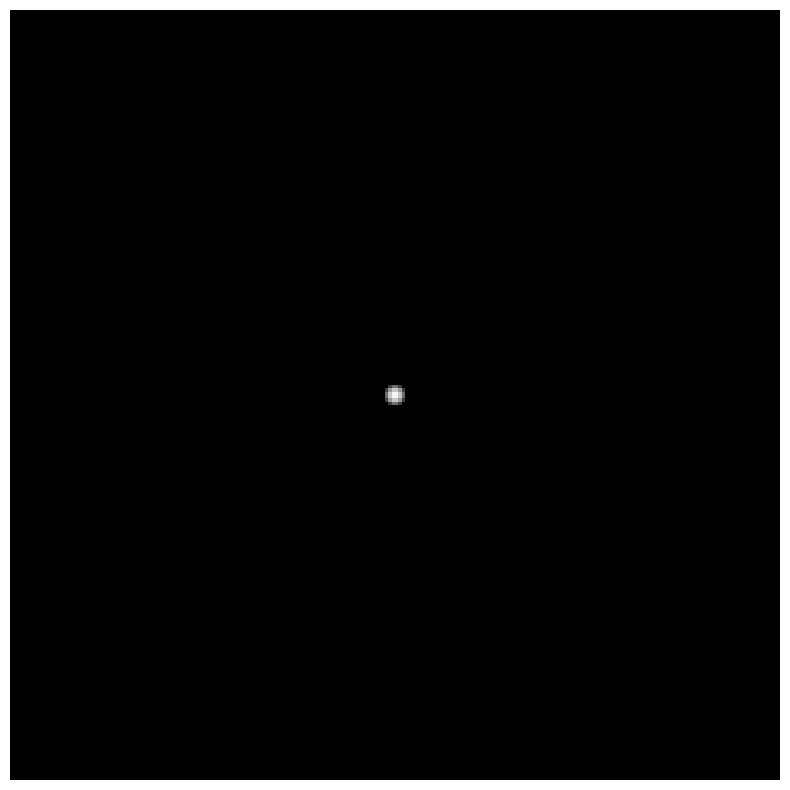

In [168]:
num_points = 1000 
size = 1
verts = (torch.rand(num_points, 3) * size) - (size/2)
rgb = torch.ones(num_points, 3).to(device)
# transform = ToPILImage()

class Model(torch.nn.Module):
    def __init__(self, verts, rgb):
        super().__init__()
        camera_pos = torch.Tensor([[0, 0, 15], [15, 0, 0], [0, 15, 0]])
        R = look_at_rotation(camera_pos)
        # R, T = look_at_view_transform(dist=[15, 15, 15], elev=[0, 0, 90], azim=[0, 90, 0])
        # R, T = look_at_view_transform(dist=torch.tensor([15, 15]), elev=torch.tensor([10, 10]), azim=torch.Tensor([0, 90]))
        cameras = FoVOrthographicCameras(device=device, R=R, znear=0.01)
        # cameras = FoVPerspectiveCameras(device=device, R=R, T=T, znear=0.01, fov=60)
        raster_settings = PointsRasterizationSettings(image_size=IMAGE_SIZE, radius = 0.03, points_per_pixel = 1)
        # Create a points renderer by compositing points using an alpha compositor (nearer points are weighted more heavily). See [1] for an explanation.
        rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
        self.renderer = PointsRenderer(
            rasterizer=rasterizer,
            compositor=AlphaCompositor()
        )
        self.verts = torch.nn.Parameter(verts, requires_grad=True)
        # self.rgb = torch.nn.Parameter(rgb, requires_grad=True)
        self.rgb = rgb.to(device)
        
    def forward(self, i):
        point_cloud = Pointclouds(points=self.verts.repeat(len(img_arr), 1, 1), features=self.rgb.repeat(len(img_arr), 1, 1))
        images = self.renderer(point_cloud)

        total_dist = torch.linalg.norm(self.verts, dim=1, ord=2)
        avg_total_dist = torch.mean(total_dist)
        
        if True or i < 0:
            loss = -torch.abs(images - img_tensor).sum() / 500
            # print('loss 1', loss.item())
        else:
            # vec = img2vec.get_vec(transform(images[0].permute(2, 0, 1)), tensor=True).requires_grad_(True)
            vec = get_vector(images[0].permute(2, 0, 1)).requires_grad_(True)
            loss = cosine_similarity(img_vec, vec, dim=0)

        loss += avg_total_dist
        # print('loss 2', loss.item())

        return loss, images, self.verts

model = Model(verts=verts, rgb=rgb).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)


for i in range(700):
    loss, images, _ = model(i)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 50 == 0:
        print('i:', i, 'loss', loss.item())
        for image in images:
            plt.figure(figsize=(10, 10))
            plt.imshow(image[..., :3].clone().detach().cpu().numpy())
            plt.axis("off")

In [169]:
with torch.no_grad():
    _, _, final_verts = model(0) 
verts_np = final_verts.clone().detach().cpu().numpy() #convert to Numpy array
df = pd.DataFrame(data=verts_np, columns=['x', 'y', 'z']) #convert to a dataframe
df.to_csv("verts.csv",index=False) 

In [9]:
renderer = PulsarPointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    n_channels=4
).to(device)

images = renderer(point_cloud, gamma=(1e-4,),
                  bg_col=torch.tensor([0.0, 1.0, 0.0, 1.0], dtype=torch.float32, device=device))
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")

/home/josephmiller/.conda/envs/perspective_point/lib/python3.8/site-packages/pytorch3d/renderer/points/pulsar/renderer.py:659: UserWarning: Extreme ratio of `max_depth` vs. focal length detected (100.000000 vs. 0.009999, ratio: 10001.000000). This will likely lead to artifacts due to numerical instabilities.
  warnings.warn(


RuntimeError: invalid argument 2: Vertex colors must have the right number of channels (have shape 3, need 4)!